In [ ]:
#mounting google drive in order to read and save data to it
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#importing
import pandas as pd
import numpy as np
import requests
import json
import time
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from tqdm import tqdm
from time import sleep
from datetime import date
from google.colab import files

In [ ]:
#read the data from drive csv
hacks = pd.read_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/hacks_data.csv') #this are all hackathons that were published in Devpost
projects = pd.read_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/all_projects_data.csv') #this are all projects that were published in Devpost
participants = pd.read_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/participants.csv')

In [ ]:
hacks = hacks.rename(columns={"submission_gallery_url": "submission_gal_url"}, errors="raise") #we rename one column here for an easier transformation in the future
hacks.submission_gal_url = hacks.submission_gal_url.astype(str) #this step was needed to be able to merge datasets (was not working without it)
projects.submission_gal_url = projects.submission_gal_url.astype(str)
hacks = hacks[~hacks['submission_gal_url'].isnull()] #we interested only in hacks for which there is a submission galery (it means that at least one project was submitted)


In [ ]:
data = projects.merge(hacks, on='submission_gal_url', how='left') #we join projects with hacks to get a more complete picture

In [ ]:
test = data[['build_with', 'submission_gal_url', 'Location']]
test.loc[test['Location'] != 'Online', 'Location'] = 'Offline' 

N_top = 20

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
test_before = test[test['Location'] == 'Online']
build_with_flatten_before = test_before['build_with'].str.split(', ', expand=True).stack()
test_before = pd.DataFrame({'build_with': build_with_flatten_before, 'count': range(len(build_with_flatten_before))})
test_before.reset_index(drop=True, inplace=True)
grouped_skills_before = test_before.groupby('build_with').count().sort_values('count', ascending=False)
grouped_skills_before_sum = grouped_skills_before.head(N_top)['count'].sum() # took only N_top!!!
grouped_skills_before_pct = grouped_skills_before.head(N_top)['count'] / grouped_skills_before_sum * 100
grouped_skills_before = grouped_skills_before.iloc[:N_top, :]
grouped_skills_before['pct'] = grouped_skills_before_pct.round(2)

In [ ]:
test_after = test[test['Location'] == 'Offline']
build_with_flatten_after = test_after['build_with'].str.split(', ', expand=True).stack()
test_after = pd.DataFrame({'build_with': build_with_flatten_after, 'count': range(len(build_with_flatten_after))})
test_after.reset_index(drop=True, inplace=True)
grouped_skills_after = test_after.groupby('build_with').count().sort_values('count', ascending=False)
grouped_skills_after_sum = grouped_skills_after.head(N_top)['count'].sum() # took only N_top!!!
grouped_skills_after_pct = grouped_skills_after.head(N_top)['count'] / grouped_skills_after_sum * 100
grouped_skills_after = grouped_skills_after.iloc[:N_top, :]
grouped_skills_after['pct'] = grouped_skills_after_pct.round(2)

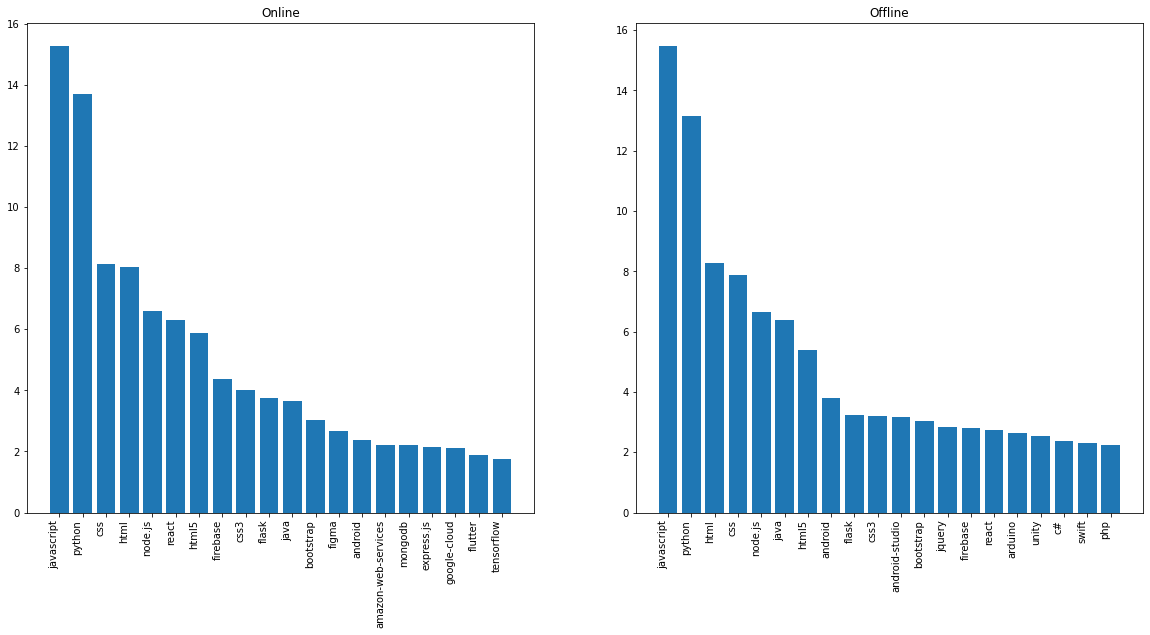

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].set_title("Online")
axs[0].bar(grouped_skills_before.index.tolist(), grouped_skills_before['pct'])

axs[1].set_title("Offline")
axs[1].bar(grouped_skills_after.index.tolist(), grouped_skills_after['pct'])

fig.autofmt_xdate(rotation=90)

In [ ]:
test_2 = hacks[['themes', 'submission_gal_url', 'Location']]
test_2.loc[test_2['Location'] != 'Online', 'Location'] = 'Offline' 

N_top = 20

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
test_2_before = test_2[test_2['Location'] == 'Online']
themes_flatten_before = test_2_before['themes'].str.split(', ', expand=True).stack()
test_2_before = pd.DataFrame({'themes': themes_flatten_before, 'count': range(len(themes_flatten_before))})
test_2_before.reset_index(drop=True, inplace=True)
grouped_themes_before = test_2_before.groupby('themes').count().sort_values('count', ascending=False)
grouped_themes_before_sum = grouped_themes_before.head(N_top)['count'].sum() # took only N_top!!!
grouped_themes_before_pct = grouped_themes_before.head(N_top)['count'] / grouped_themes_before_sum * 100
grouped_themes_before = grouped_themes_before.iloc[:N_top, :]
grouped_themes_before['pct'] = grouped_themes_before_pct.round(2)

In [ ]:
test_2_after = test_2[test_2['Location'] == 'Offline']
themes_flatten_after = test_2_after['themes'].str.split(', ', expand=True).stack()
test_2_after = pd.DataFrame({'themes': themes_flatten_after, 'count': range(len(themes_flatten_after))})
test_2_after.reset_index(drop=True, inplace=True)
grouped_themes_after = test_2_after.groupby('themes').count().sort_values('count', ascending=False)
grouped_themes_after_sum = grouped_themes_after.head(N_top)['count'].sum() # took only N_top!!!
grouped_themes_after_pct = grouped_themes_after.head(N_top)['count'] / grouped_themes_after_sum * 100
grouped_themes_after = grouped_themes_after.iloc[:N_top, :]
grouped_themes_after['pct'] = grouped_themes_after_pct.round(2)

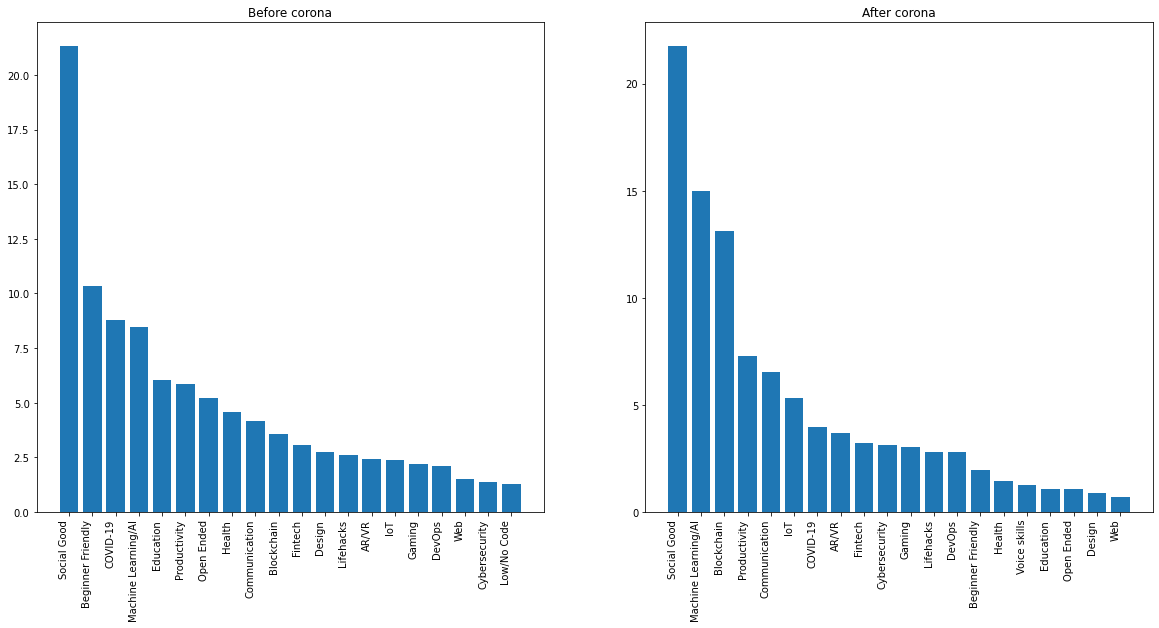

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].set_title("Before corona")
axs[0].bar(grouped_themes_before.index.tolist(), grouped_themes_before['pct'])

axs[1].set_title("After corona")
axs[1].bar(grouped_themes_after.index.tolist(), grouped_themes_after['pct'])

fig.autofmt_xdate(rotation=90)

In [ ]:
test_3 = hacks[['Criteria', 'submission_gal_url', 'Location']]
test_3.loc[test_2['Location'] != 'Online', 'Location'] = 'Offline' 

N_top = 20

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
test_3_before = test_3[test_3['Location'] == 'Online']
criteria_flatten_before = test_3_before['Criteria'].str.split(', ', expand=True).stack()
test_3_before = pd.DataFrame({'Criteria': criteria_flatten_before, 'count': range(len(criteria_flatten_before))})
test_3_before.reset_index(drop=True, inplace=True)
grouped_criteria_before = test_3_before.groupby('Criteria').count().sort_values('count', ascending=False)
grouped_criteria_before_sum = grouped_criteria_before.head(N_top)['count'].sum() # took only N_top!!!
grouped_criteria_before_pct = grouped_criteria_before.head(N_top)['count'] / grouped_criteria_before_sum * 100
grouped_criteria_before = grouped_criteria_before.iloc[:N_top, :]
grouped_criteria_before['pct'] = grouped_criteria_before_pct.round(2)

In [ ]:
test_3_after = test_3[test_3['Location'] == 'Offline']
criteria_flatten_after = test_3_after['Criteria'].str.split(', ', expand=True).stack()
test_3_after = pd.DataFrame({'Criteria': criteria_flatten_after, 'count': range(len(criteria_flatten_after))})
test_3_after.reset_index(drop=True, inplace=True)
grouped_criteria_after = test_3_after.groupby('Criteria').count().sort_values('count', ascending=False)
grouped_criteria_after_sum = grouped_criteria_after.head(N_top)['count'].sum() # took only N_top!!!
grouped_criteria_after_pct = grouped_criteria_after.head(N_top)['count'] / grouped_criteria_after_sum * 100
grouped_criteria_after = grouped_criteria_after.iloc[:N_top, :]
grouped_criteria_after['pct'] = grouped_criteria_after_pct.round(2)

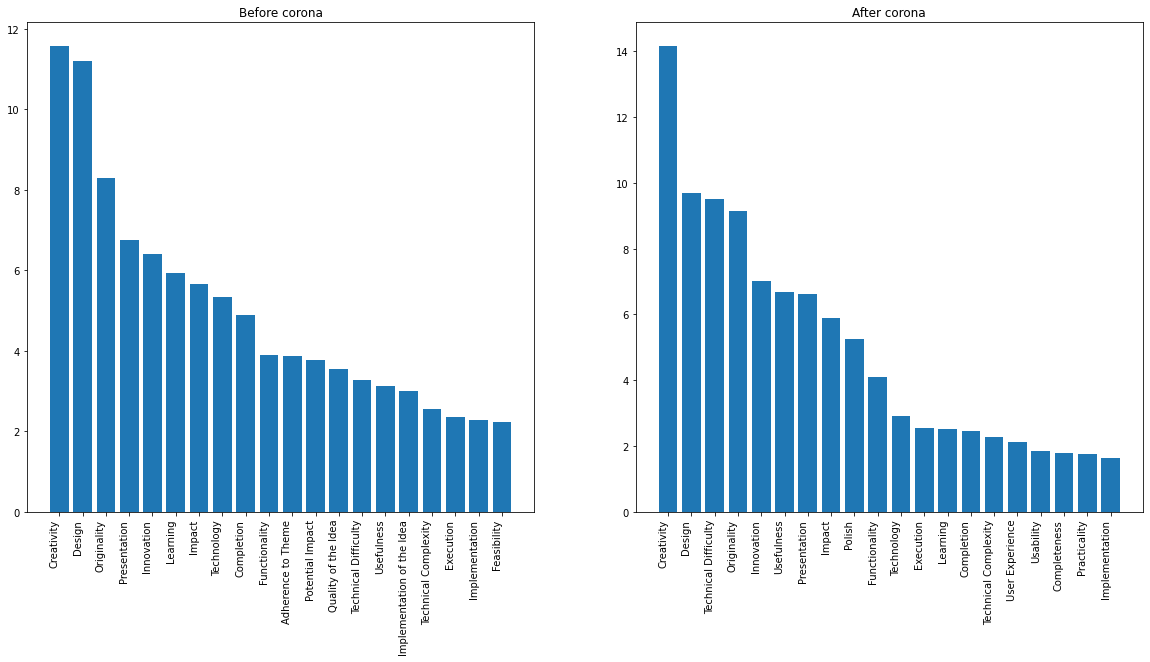

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].set_title("Before corona")
axs[0].bar(grouped_criteria_before.index.tolist(), grouped_criteria_before['pct'])

axs[1].set_title("After corona")
axs[1].bar(grouped_criteria_after.index.tolist(), grouped_criteria_after['pct'])

fig.autofmt_xdate(rotation=90)

## Geopy data acquisition
1. Get all projects' participants
2. Get location that was stated by participants 
3. Using geopy get latitude and longtitude of participants
4. Using geopy and latitude and longtitude from previous step get standartised country name in English (this is needed to transform all namings in other languages, for example O`zbekiston to Uzbekistan, in order to aggregate data in the future and get accurate results)

## 1. Get all projects participoants

In [ ]:
participants_flatten = data['participants'].str.split(', ', expand=True).stack() #here we get all participants in projects and split it using comma separator (as far as initially they were combined in 1)
participants_flatten = pd.DataFrame(participants_flatten, columns=['0']) 
country_data = participants_flatten.merge(participants, on='0', how='left') #we merge it with information about this participants, in particular to get country

## 1. Get locations that was stated by participants

In [ ]:
all_countries = country_data[['country']] #creating DataFrame with all possible countries
all_countries['country'].replace({'J & K': 'India', "Ari'el": 'Israel'}, inplace=True) #we made some renaming for locations that can't be found in OpenStreetMap
all_countries = all_countries.drop_duplicates() #make df unique
all_countries = all_countries[~all_countries['country'].isnull()] #removing null values
all_countries = all_countries.loc[all_countries['country']!='Nan'] #removing Nan values
all_countries.reset_index(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


## 3. Using geopy get latitude and lontitude od participants' locations 

Here we install required packages and import additional libraries

In [ ]:
pip install geopy

In [ ]:
import geopy

from geopy.geocoders import Nominatim
nom = Nominatim(timeout=10)

/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


In [ ]:
coords = []
for ind, row in all_countries.iterrows():
  try:
    coord = nom.geocode(row['country'])
    coords.append((coord.latitude, coord.longitude))
  except:
    print(f"Timeout error in row {ind}")
    coords.append((None, None))

In [ ]:
all_countries['lat'] = [c[0] for c in coords]
all_countries['lon'] = [c[1] for c in coords]

After this step not all latitude and longtitude were found, so we created a list of empty locations and get only first imput (in majority of cases it's city or state). For example if the location was Yaroslavl, Yaroslavskays oblast, Russia and full location was not found in Open Street Map, we will try to find first input of this location which is Yaroslavl. 

In [ ]:
all_countries.to_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/Locations_iterations/1_iter_full_location.csv', index=False)
empty_countries.to_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/Locations_iterations/2_iter_shorten_location.csv', index=False)
empty_countries_2.to_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/Locations_iterations/3_iter_shorten_location_2.csv', index=False)
empty_countries_3.to_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/Locations_iterations/4_iter_country_level.csv', index=False)

In [ ]:
empty_countries = all_countries[all_countries['lat'].isnull()] #we create a list of empty locations
empty_countries['shorten_location'] = empty_countries['country'].str.split(',').str[0].str.strip() #and get furst entry in location string

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Here we run the same code as before, but the input is not the full location but only first entry

In [ ]:
coords_2 = []
for ind, row in empty_countries.iterrows():
  try:
    coord_2 = nom.geocode(row['shorten_location'])
    coords_2.append((coord_2.latitude, coord_2.longitude))
  except:
    print(f"Timeout error in row {ind}")
    coords_2.append((None, None))

In [ ]:
empty_countries['lat'] = [c[0] for c in coords_2]
empty_countries['lon'] = [c[1] for c in coords_2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


However, after this step we still have had some empty locations, so we did all the same but using secont entry in location. For example, if the full location was Yaroslavl, Yaroslavskays oblast, Russia and full location was not found in Open Street Map, first entry was also not found, we will try to find second input of this location which is Yaroslavskays oblast. This is not an ideal solution (for example, when participant stated that his location is "Tilonia, RJ, India" which is in India, if Open Street Map didn't found full location and city, we will run it on RJ and it would be latitude and longtitude of Rio de Janeiro - this cases are rare, but they can happen), but it works in majority of cases.

In [ ]:
empty_countries_2 = empty_countries[empty_countries['lat'].isnull()]
empty_countries_2['shorten_location_2'] = empty_countries_2['country'].str.split(',').str[1].str.strip()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
coords_3 = []
for ind, row in empty_countries_2.iterrows():
  try:
    coord_3 = nom.geocode(row['shorten_location_2'])
    coords_3.append((coord_3.latitude, coord_3.longitude))
  except:
    print(f"Timeout error in row {ind}")
    coords_3.append((None, None))

Timeout error in row 4274
Timeout error in row 9227


In [ ]:
empty_countries_2['lat'] = [c[0] for c in coords_3]
empty_countries_2['lon'] = [c[1] for c in coords_3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


After this step we were able to get almost all locations. However, some are still empty and for this we rerun the code on empty locations using the very last entry. In our example it would be Yaroslavl. 

In [ ]:
empty_countries_3 = empty_countries_2[empty_countries_2['lat'].isnull()]
empty_countries_3['shorten_location_3'] = empty_countries_3['country'].str.split(',').str[-1].str.strip()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
coords_4 = []
for ind, row in empty_countries_3.iterrows():
  try:
    coord_4 = nom.geocode(row['shorten_location_3'])
    coords_4.append((coord_4.latitude, coord_4.longitude))
  except:
    print(f"Timeout error in row {ind}")
    coords_4.append((None, None))

In [ ]:
empty_countries_3['lat'] = [c[0] for c in coords_4]
empty_countries_3['lon'] = [c[1] for c in coords_4]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#now we will delete all empty values and concat 4 tables into 1, after which we will save it to csv 
all_countries = all_countries.dropna()
empty_countries = empty_countries.dropna()
empty_countries_2 = empty_countries_2.dropna()
empty_countries_3 = empty_countries_3.dropna()
all = pd.concat([all_countries, empty_countries, empty_countries_2, empty_countries_3], ignore_index=True)
all.to_csv(r'/content/drive/MyDrive/Thesis/data/Data_all/all_locations_cleaned.csv', index=False)